In [3]:
#!pip install prophet
#!pip install keras-tuner

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Model imports
from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import keras_tuner as kt  # For LSTM hyperparameter tuning

In [5]:
df = pd.read_csv("/content/AAPL (1).csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
...,...,...,...,...,...,...,...
2006,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2007,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2008,2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2009,2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2011 non-null   object 
 1   Open       2011 non-null   float64
 2   High       2011 non-null   float64
 3   Low        2011 non-null   float64
 4   Close      2011 non-null   float64
 5   Adj Close  2011 non-null   float64
 6   Volume     2011 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 110.1+ KB


In [7]:
df.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [8]:
df[df.duplicated()]

,Date,Open,High,Low,Close,Adj Close,Volume


In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2011 non-null   datetime64[ns]
 1   Open       2011 non-null   float64       
 2   High       2011 non-null   float64       
 3   Low        2011 non-null   float64       
 4   Close      2011 non-null   float64       
 5   Adj Close  2011 non-null   float64       
 6   Volume     2011 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 110.1 KB


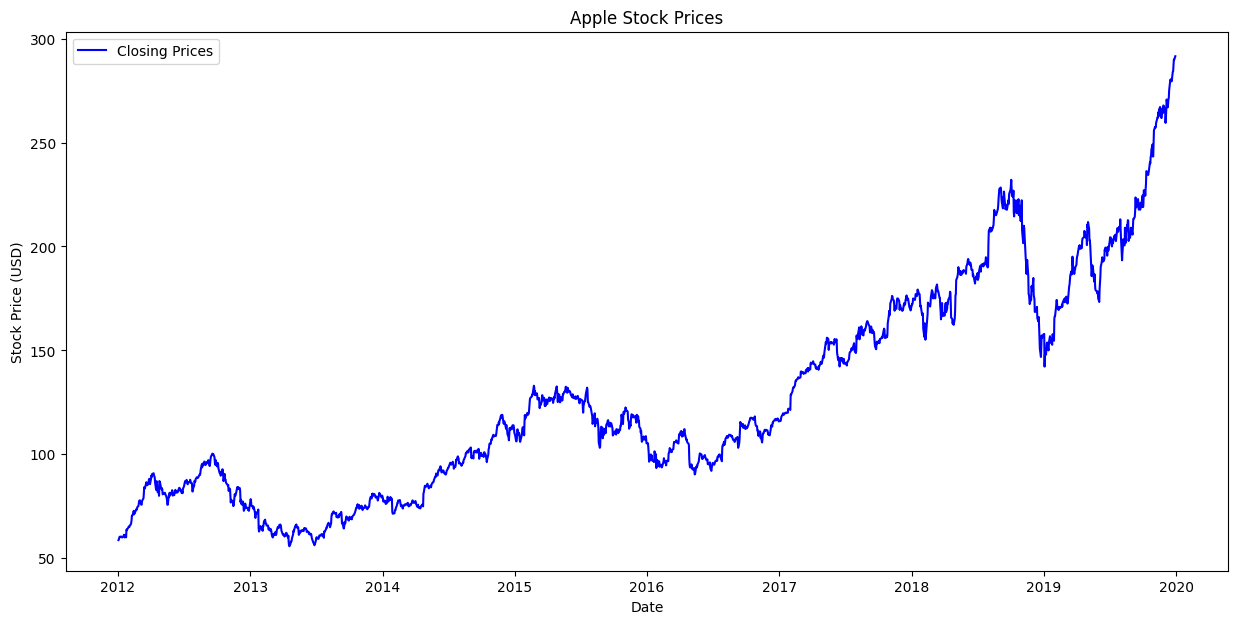

In [11]:
# Plot the closing prices
plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['Close'], label='Closing Prices', color='blue')
plt.title("Apple Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

In [12]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler

MinMaxScaler()

In [14]:
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [15]:
scaled_train = scaled_data[:train_size]
scaled_test = scaled_data[train_size:]

In [16]:
print(f"Training data size: {len(train)}")
print(f"Test data size: {len(test)}")

Training data size: 1608
Test data size: 403


In [17]:
def adf_test(data):
    result = adfuller(data)
    print(f'ADF Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Number of Lags: {result[2]}')
    print(f'Number of Observations Used: {result[3]}')
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'\t{key}, {value}')

In [18]:
# Check for stationarity
if not adf_test(train['Close']):
    train['Close_diff'] = train['Close'] - train['Close'].shift(1)
    train.dropna(inplace=True)

ADF Test Statistic: 0.09475682688784107
p-value: 0.9657012897826207
Number of Lags: 11
Number of Observations Used: 1596
Critial Values:
	1%, -3.434453915243171
	5%, -2.863352636968251
	10%, -2.5677350125470317


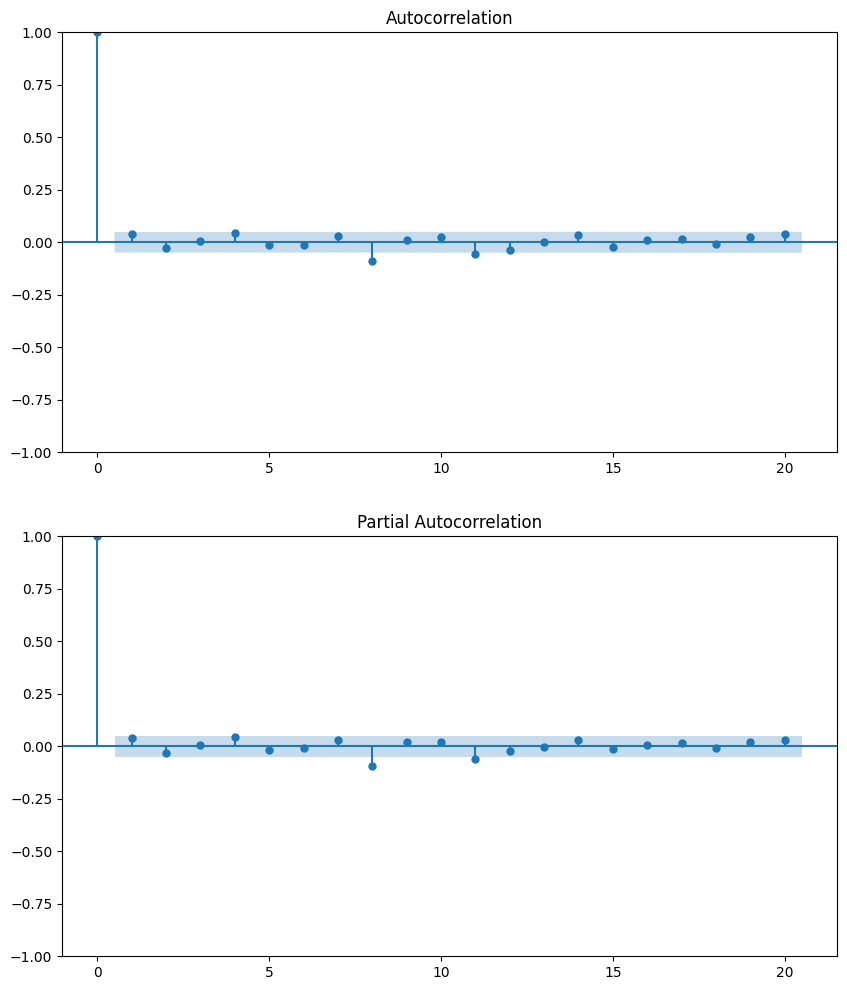

In [19]:
fig, ax = plt.subplots(2 ,1, figsize=(10, 12))
plot_acf(train['Close_diff'], lags=20, ax=ax[0])
plot_pacf(train['Close_diff'], lags=20, ax=ax[1])
plt.show()

In [20]:
# Set index for SARIMA
train_sarima = train.set_index('Date')['Close']

In [21]:
sarima_model = sm.tsa.statespace.SARIMAX(
    train_sarima,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
sarima_results = sarima_model.fit()

In [23]:
sarima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 1607
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3088.764
Date:                            Thu, 21 Nov 2024   AIC                           6187.527
Time:                                    03:32:20   BIC                           6214.397
Sample:                                         0   HQIC                          6197.507
                                           - 1607                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2814      0.451     -0.623      0.533      -1.166       0.603
ma.L1          0.3233      0.448      0.722      0.470      -0.554       1.200
ar.S.L12      -0.0312      0.026     -1.184      0.236      -0.083       0.020
ma.S.L12      -0.9975      0.047    -21.395      0.000      -1.089      -0.906
sigma2         2.7256      0.124     21.912      0.000       2.482       2.969
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               912.81
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.79   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Generate predictions
sarima_train_pred = sarima_results.predict(start=0, end=len(train)-1)
sarima_test_pred = sarima_results.forecast(len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [25]:
# Evaluate SARIMA
sarima_rmse = np.sqrt(mean_squared_error(test['Close'], sarima_test_pred))
sarima_r2 = r2_score(test['Close'], sarima_test_pred)

In [26]:
print(f"SARIMA RMSE: {sarima_rmse:.4f}")
print(f"SARIMA R2: {sarima_r2:.4f}")

SARIMA RMSE: 26.3543
SARIMA R2: 0.2270


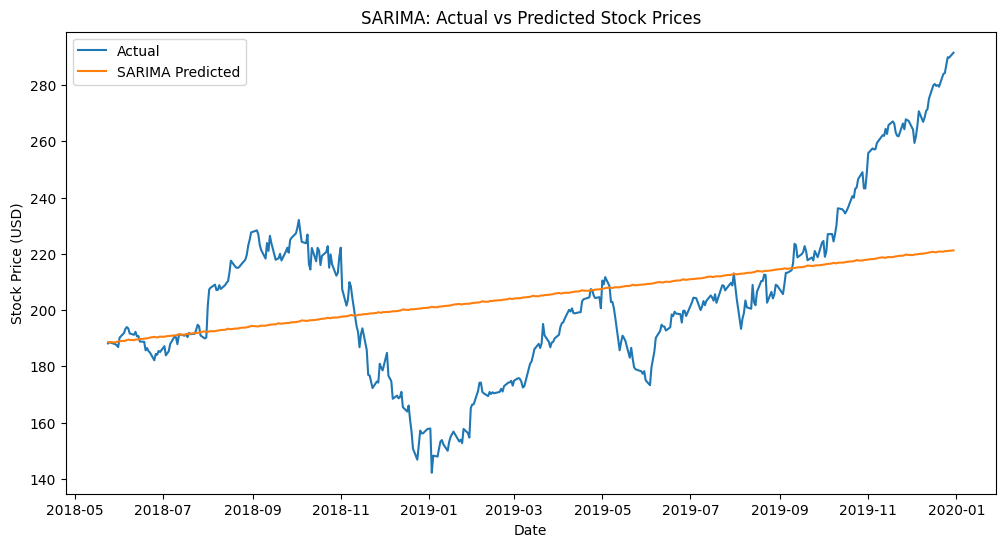

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['Close'], label='Actual')
plt.plot(test['Date'], sarima_test_pred, label='SARIMA Predicted')
plt.title('SARIMA: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

In [28]:
# Prepare data for Prophet
prophet_train = train[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

In [29]:
prophet_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1607 entries, 1 to 1607
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1607 non-null   datetime64[ns]
 1   y       1607 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 37.7 KB


In [30]:
# Fit Prophet model
prophet_model = Prophet()
prophet_model

In [31]:
prophet_model.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxbhr61up/7c1uj8d9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxbhr61up/yj4nxlki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25551', 'data', 'file=/tmp/tmpxbhr61up/7c1uj8d9.json', 'init=/tmp/tmpxbhr61up/yj4nxlki.json', 'output', 'file=/tmp/tmpxbhr61up/prophet_modeluememrut/prophet_model-20241121033221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:32:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:32:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [32]:
# Make future predictions
future_dates = prophet_model.make_future_dataframe(periods=len(test))

In [33]:
forecast = prophet_model.predict(future_dates)

In [34]:
# Evaluate Prophet
prophet_test_pred = forecast['yhat'][-len(test):]

In [35]:
prophet_rmse = np.sqrt(mean_squared_error(test['Close'], prophet_test_pred))
prophet_r2 = r2_score(test['Close'], prophet_test_pred)

In [36]:
print(f"Prophet RMSE: {prophet_rmse:.4f}")
print(f"Prophet R2: {prophet_r2:.4f}")

Prophet RMSE: 26.1900
Prophet R2: 0.2366


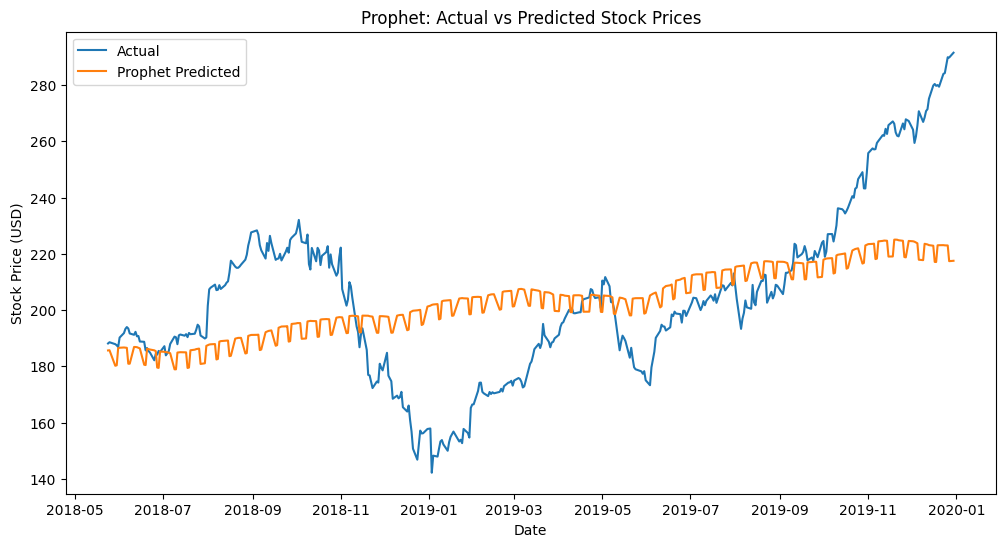

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['Close'], label='Actual')
plt.plot(test['Date'], prophet_test_pred, label='Prophet Predicted')
plt.title('Prophet: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

In [38]:
# Create sequences for LSTM
def create_lstm_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [39]:
time_step = 60
X_train, y_train = create_lstm_sequences(scaled_train, time_step)
X_test, y_test = create_lstm_sequences(scaled_test, time_step)

In [40]:
# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [41]:
X_train.shape

(1547, 60, 1)

In [42]:
model = Sequential()
model.add(Input(shape=(X_train.shape[0],1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [43]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1547, 50)            │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1547, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.1057 - val_loss: 0.0582
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0282 - val_loss: 0.0374
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0212 - val_loss: 0.0339
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0200 - val_loss: 0.0574
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 - val_loss: 0.0356
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0176 - val_loss: 0.0293
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0180 - val_loss: 0.0243
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - val_loss: 0.0289
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - val_loss: 0.0246
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151 - val_loss: 0.0214
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0148 - val_loss: 0.0220
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 -

In [46]:
# Predict the prices on the test dataset
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [47]:
# Inverse transform the actual prices for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [48]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_prices))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 5.075581033183655


In [49]:
r2 = r2_score(y_test_actual, predicted_prices)
print(f"R-squared: {r2}")

R-squared: 0.9742234132909748


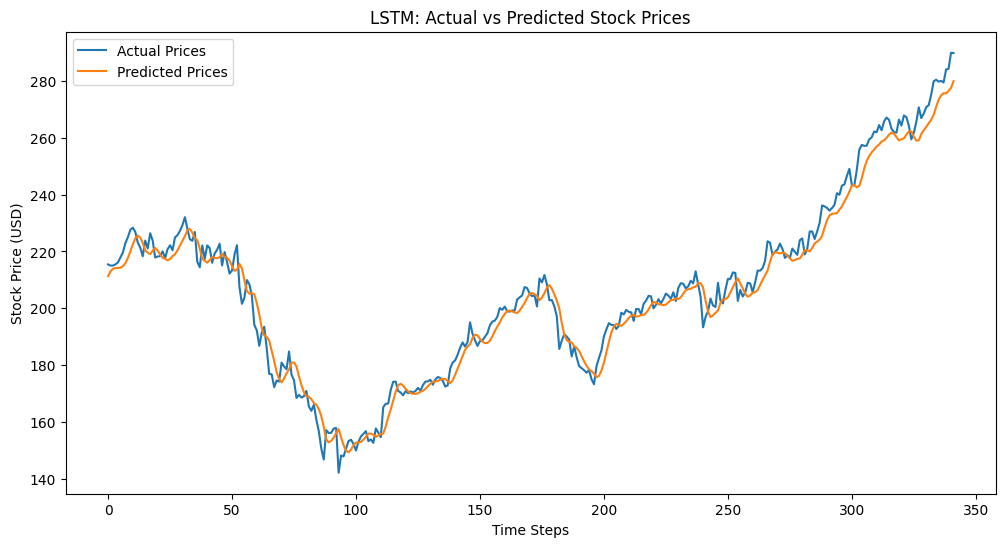

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('LSTM: Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

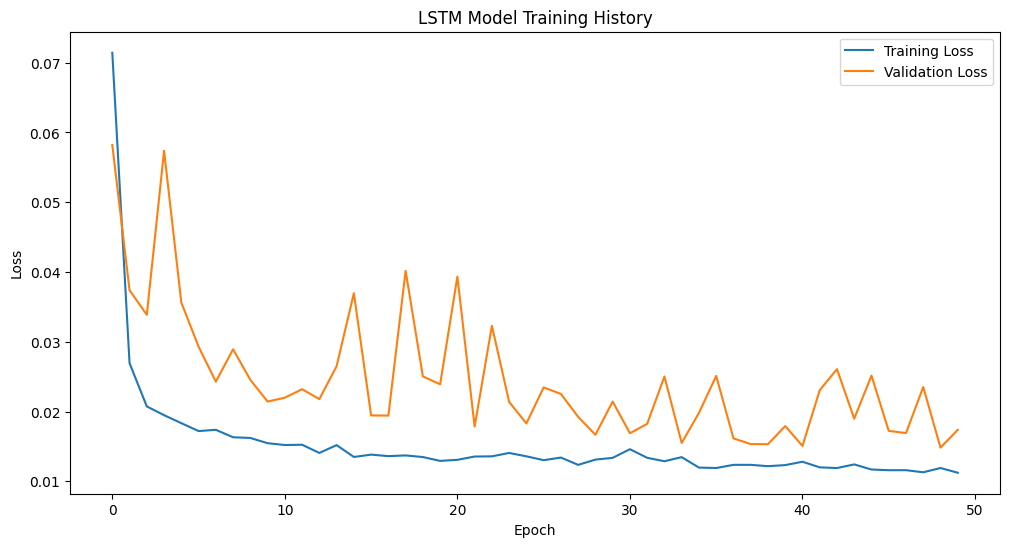

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
import tensorflow as tf

In [53]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    # Tune the number of units in the first LSTM layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=hp_units1, return_sequences=True))
    model.add(Dropout(0.3))
    # Tune the number of units in the second LSTM layer
    hp_units2 = hp.Int('units2', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=hp_units2, return_sequences=False))
    model.add(Dropout(0.3))
    # Tune the number of units in the dense layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=16)
    model.add(Dense(units=hp_units3))
    model.add(Dense(1))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Adjust the number of trials as needed
    executions_per_trial=1,
    directory='my_dir',
    project_name='stock_price_prediction'
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 15s]
val_loss: 0.015862390398979187

Best val_loss So Far: 0.015862390398979187
Total elapsed time: 00h 01m 16s


In [54]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps}")

Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7fa7f05af460>


In [55]:
# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test))

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0743 - val_loss: 0.0278
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0198 - val_loss: 0.0387
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0186 - val_loss: 0.0347
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0172 - val_loss: 0.0233
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - val_loss: 0.0336
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - val_loss: 0.0367
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0170 - val_loss: 0.0258
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139 - val_loss: 0.0285
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155 - val_loss: 0.0200
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0136 - val_loss: 0.0182
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131 - val_loss: 0.0283
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 

In [56]:
lstm_test_pred = scaler.inverse_transform(model.predict(X_test)).flatten()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [57]:
lstm_rmse = np.sqrt(mean_squared_error(test['Close'][60:60 + len(lstm_test_pred)], lstm_test_pred))
lstm_r2 = r2_score(test['Close'][60:60 + len(lstm_test_pred)], lstm_test_pred)

In [58]:
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM R2: {lstm_r2:.4f}")

LSTM RMSE: 4.0719
LSTM R2: 0.9834


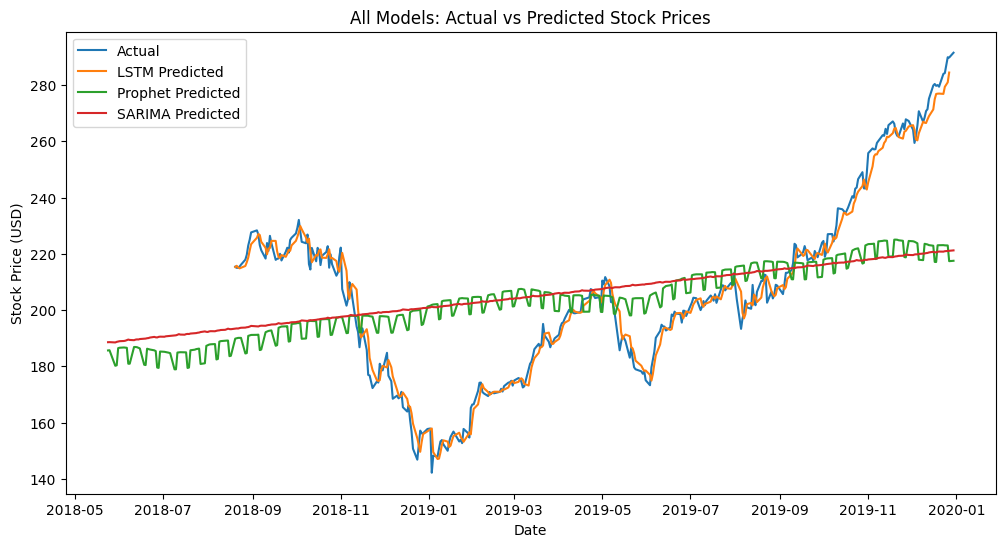

In [59]:
# prompt: plot for compare all models based on actual vs predicted

plt.figure(figsize=(12, 6))
plt.plot(test['Date'][60:], test['Close'][60:], label='Actual')
plt.plot(test['Date'][60:60 + len(lstm_test_pred)], lstm_test_pred, label='LSTM Predicted')
plt.plot(test['Date'], prophet_test_pred, label='Prophet Predicted')
plt.plot(test['Date'], sarima_test_pred, label='SARIMA Predicted')

plt.title('All Models: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

In [60]:
# Display RMSE and R2 scores
print("\nModel Performance:")
print(f"SARIMA -> RMSE: {sarima_rmse:.4f}, R2: {sarima_r2:.4f}")
print(f"Prophet -> RMSE: {prophet_rmse:.4f}, R2: {prophet_r2:.4f}")
print(f"LSTM   -> RMSE: {lstm_rmse:.4f}, R2: {lstm_r2:.4f}")


Model Performance:
SARIMA -> RMSE: 26.3543, R2: 0.2270
Prophet -> RMSE: 26.1900, R2: 0.2366
LSTM   -> RMSE: 4.0719, R2: 0.9834


In [62]:
import joblib

# Save the LSTM model
model.save('lstm_model.h5')

# Save the MinMaxScaler
joblib.dump(scaler, 'min_max_scaler.pkl')